# contrasts_pond_core_properties

Notebook to injest ice core data from spreadsheets and compare bare ice and pond ice properties

@author: David Clemens-Sewall

In [184]:
import os
import glob
import re
import warnings
from datetime import datetime, timezone

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from openpyxl import load_workbook
from matplotlib.colors import Normalize
from matplotlib.ticker import FixedFormatter

%matplotlib inline

In [3]:
# Paths
ic_data_root = os.path.join('..', 'data', 'ice_coring')

In [240]:
# Ice core data is very complicated, especially the vertical reference frame
# Define a class for representing ice cores
class IceCore:
    """
    Class representing data from an individual ice core.

    Attributes:
        station (str): Station number (1, 2, or 3) as a string.
        visit (str): Visit letter ([a-d]).
        file_path (str): Path to the xlsx file containing core data.
        core (str): Name of the core.
        site (str): Site name
        timestamp (datetime.datetime): Timestamp for the core.
        hi (float): Ice thickness (measured by a thickness gauge) in meters.
        draft (float): Draft (measured by a thickness gauge) in meters.
        length (float): Total core length in meters.
        freeboard (float): Freeboard (ice thickness - draft) in meters.
        snow_depths (array): Array of snow depths in meters.
        hs (float): Mean snow depth in meters.
        hp (float): Pond depth in meters.
        ponded (bool): Whether the ice was ponded.
        age (str): Sea ice age.
        data (Pandas.DataFrame): Dataframe containing data for this core.
        comments (Pandas.DataFrame): Dataframe containing comments for this core.
        units (dict): Mapping of variable names in self.data to units.
        variables (list): List of data variables that this ice core has.
    """
    
    def __init__(self, station, visit, file_path):
        """
        Initialize an IceCore object and load basic core metadata.

        Parameters:
            station (str): Station number (1, 2, or 3) as a string.
            visit (str): Visit letter ([a-d]).
            file_path (str): Path to the xlsx file containing core data.
        """
        # Store attributes
        self.station = station
        self.visit = visit
        self.file_path = file_path

        # Open excel workbook
        wb = load_workbook(file_path, read_only=True, data_only=True)
        ws_core = wb['metadata-core']
        ws_coring = wb['metadata-coring']

        # Get the core name from the workbook and check that it matches the filename
        core_fn = os.path.basename(file_path)[:-5]
        core_wb = ws_core['C1'].value
        if core_fn != core_wb:
            warnings.warn(f"Core name from filename does not match workbook, using core name from file: {core_fn}",
                          category=RuntimeWarning)
        self.core = core_fn
        self.site = ws_coring['C4'].value

        ## Get basic parameters
        # time
        if ws_core['D2'].value == 'UTC':
            tzinfo = timezone.utc
        else:
            raise RuntimeError('Timezone is not UTC, need to implement support for other timezones')
        date = ws_core['C2'].value
        time = ws_core['C3'].value
        if time is None:
            time = ws_coring['C13'].value
        self.timestamp = datetime.combine(date, time, tzinfo=tzinfo)
        # ice measurements
        self.hi = ws_core['C7'].value
        self.draft = ws_core['C8'].value
        self.freeboard = ws_core['C9'].value
        self.length = ws_core['C10'].value
        if self.length is None:
            raise RuntimeError(f"{self.core} is missing core length")
        # Account for potential missing core data
        if self.hi is None:
            warnings.warn(f"{self.core} is missing ice thickness, using core length",
                          category=RuntimeWarning)
            self.hi = self.length
        if (self.draft is None) and (self.freeboard is None):
            warnings.warn(f"{self.core} is missing freeboard and draft",
                         category=RuntimeWarning)
        elif self.freeboard is None:
            self.freeboard = self.hi - self.draft
        elif self.draft is None:
            self.draft = self.hi - self.freeboard
        self.age = ws_coring['C20'].value
        # snow measurements
        for value in ws_coring.iter_rows(min_row=16, max_row=16, min_col=3, max_col=8, values_only=True):
            self.snow_depths = np.array(value, dtype=float)
        if np.isnan(self.snow_depths).all():
            self.hs = 0
        else:
            self.hs = np.nanmean(self.snow_depths)
        # pond measurements
        self.hp = ws_coring['C19'].value
        if self.hp is None:
            self.ponded = False
            self.hp = 0
        else:
            self.ponded = True

        ## Initialize the data and comments dataframes
        idx = pd.MultiIndex.from_tuples([], names=('variable', 'depth_top', 'depth_bottom', 'depth_center'))
        self.data = pd.DataFrame(columns=['value'], index=idx)
        self.comments = pd.DataFrame(columns=['description', 'comment'], index=idx)
        self.units = {}
        self.variables = []
        wb.close()

    def load_salinity(self):
        """Loads salinity data if present in file."""

        # Get temperature sheet
        wb = load_workbook(self.file_path, read_only=True, data_only=True)
        ws = wb['SALO18']

        # If there is no data at all in the temperature sheet, return
        if ws['A5'].value is None:
            return
        # Read in values
        ls_d_t = []
        ls_d_b = []
        ls_s = []
        ls_c = []
        for row in ws.iter_rows(min_row=5, min_col=1, max_col=14):
            d_t = row[0].value
            if d_t is None:
                break
            else:
                ls_d_t.append(d_t)
                ls_d_b.append(row[1].value)
                ls_s.append(row[4].value)
                ls_c.append(row[13].value)
        # Create temporary dataframes and concatenate
        df_data_temp = pd.DataFrame({'variable': 'salinity',
                                     'depth_top': ls_d_t,
                                     'depth_bottom': ls_d_b,
                                     'depth_center': np.nan,
                                     'value': ls_s})
        df_data_temp['depth_center'] = (df_data_temp['depth_top'] + df_data_temp['depth_bottom'])/2.0
        df_data_temp.set_index(['variable', 'depth_top', 'depth_bottom', 'depth_center'],
                               inplace=True)
        df_comm_temp = pd.DataFrame({'variable': 'salinity',
                                     'depth_top': ls_d_t,
                                     'depth_bottom': ls_d_b,
                                     'depth_center': np.nan,
                                     'description': '',
                                     'comment': ls_c})
        df_comm_temp['depth_center'] = (df_comm_temp['depth_top'] + df_comm_temp['depth_bottom'])/2.0
        df_comm_temp.set_index(['variable', 'depth_top', 'depth_bottom', 'depth_center'],
                               inplace=True)
        self.data = pd.concat([self.data, df_data_temp])
        self.comments = pd.concat([self.comments, df_comm_temp])
        # Update variables and units fields
        self.variables.append('salinity')
        self.units['salinity'] = ws['E4'].value
        wb.close()

    def load_densimetry(self):
        """Loads densimetry data if present in file."""

        # Get temperature sheet
        wb = load_workbook(self.file_path, read_only=True, data_only=True)
        ws = wb['Density-densimetry']

        # If there is no data at all in the temperature sheet, return
        if ws['A4'].value is None:
            return
        # Read in values
        ls_d_t = []
        ls_d_b = []
        ls_r = []
        ls_c = []
        for row in ws.iter_rows(min_row=4, min_col=1, max_col=8):
            d_t = row[0].value
            if d_t is None:
                break
            else:
                ls_d_t.append(d_t)
                ls_d_b.append(row[1].value)
                ls_r.append(row[6].value)
                ls_c.append(row[7].value)
        # Create temporary dataframes and concatenate
        df_data_temp = pd.DataFrame({'variable': 'density',
                                     'depth_top': ls_d_t,
                                     'depth_bottom': ls_d_b,
                                     'depth_center': np.nan,
                                     'value': ls_r})
        df_data_temp['depth_center'] = (df_data_temp['depth_top'] + df_data_temp['depth_bottom'])/2.0
        df_data_temp.set_index(['variable', 'depth_top', 'depth_bottom', 'depth_center'],
                               inplace=True)
        df_comm_temp = pd.DataFrame({'variable': 'density',
                                     'depth_top': ls_d_t,
                                     'depth_bottom': ls_d_b,
                                     'depth_center': np.nan,
                                     'description': '',
                                     'comment': ls_c})
        df_comm_temp['depth_center'] = (df_comm_temp['depth_top'] + df_comm_temp['depth_bottom'])/2.0
        df_comm_temp.set_index(['variable', 'depth_top', 'depth_bottom', 'depth_center'],
                               inplace=True)
        self.data = pd.concat([self.data, df_data_temp])
        self.comments = pd.concat([self.comments, df_comm_temp])
        # Update variables and units fields
        self.variables.append('density')
        self.units['density'] = ws['G3'].value
        wb.close()

    def load_temperature(self):
        """Loads temperature data if present in file."""

        # Get temperature sheet
        wb = load_workbook(self.file_path, read_only=True, data_only=True)
        ws = wb['TEMP']

        # If there is no data at all in the temperature sheet, return
        if ws['A4'].value is None:
            return
        # Read in values
        ls_d_c = []
        ls_t = []
        ls_c = []
        for row in ws.iter_rows(min_row=4, min_col=1, max_col=3):
            d_c = row[0].value
            if d_c is None:
                break
            else:
                ls_d_c.append(d_c)
                ls_t.append(row[1].value)
                ls_c.append(row[2].value)
        # Create temporary dataframes and concatenate
        df_data_temp = pd.DataFrame({'variable': 'temperature',
                                     'depth_top': np.nan,
                                     'depth_bottom': np.nan,
                                     'depth_center': ls_d_c,
                                     'value': ls_t})
        df_data_temp.set_index(['variable', 'depth_top', 'depth_bottom', 'depth_center'],
                               inplace=True)
        df_comm_temp = pd.DataFrame({'variable': 'temperature',
                                     'depth_top': np.nan,
                                     'depth_bottom': np.nan,
                                     'depth_center': ls_d_c,
                                     'description': '',
                                     'comment': ls_c})
        df_comm_temp.set_index(['variable', 'depth_top', 'depth_bottom', 'depth_center'],
                               inplace=True)
        self.data = pd.concat([self.data, df_data_temp])
        self.comments = pd.concat([self.comments, df_comm_temp])
        # Update variables and units fields
        self.variables.append('temperature')
        self.units['temperature'] = ws['B3'].value
        wb.close()

    def plot_profile(self, ax, variable, z_ref='ice top', z_scale='absolute',
                     kind='center', linestyle='solid', color = 'C0',
                    markersize=3):
        """
        Plots a profile of a single variable from the ice core following various conventions

        Parameters:
            ax (Matplotlib Axes): Axes to plot on.
            variable (str): Variable to plot, must be in self.data
            z_ref (str): Vertical reference for profile, must be one of ['ice top',
                'sea surface', 'pond surface']. The default is 'ice top'.
            z_scale (str): How to scale z values, must be one of ['absolute', 
                'relative']. The default is 'absolute'.
            kind (str): Whether to plot values at the 'center' of ice segments
                or as a line spanning entire segment ('segment') the default is 'center'.
            linestyle (str): Line style for line.
            color (color for Matplotlib): Line color.
            markersize (float): Marker size

        Returns:
            Handle from matplotlib object.
        """
        
        # z_ref_dict for converting z_ref into z values
        z_ref_dict = {'ice top': 0,
                      'sea surface': self.freeboard,
                      'pond surface': -self.hp
                     }
        z_unit_dict = {'absolute': 'm',
                       'relative': '1',
                      }
        # Get data
        df_plot = self.data.query('variable == @variable').reset_index()
        # Adjust for z-reference
        df_plot['z_t'] = z_ref_dict[z_ref] - df_plot['depth_top']
        df_plot['z_b'] = z_ref_dict[z_ref] - df_plot['depth_bottom']
        df_plot['z_c'] = z_ref_dict[z_ref] - df_plot['depth_center']
        # If scale is relative, adjust for relative vertical position
        if z_scale == 'relative':
            if z_ref == 'pond surface':
                z_top = 0
                z_bottom = -self.hp - self.length
            else:
                z_top = z_ref_dict[z_ref]
                z_bottom = z_top - self.length
            df_plot['z_t'] = (df_plot['z_t'] - z_bottom) / (z_top - z_bottom)
            df_plot['z_b'] = (df_plot['z_b'] - z_bottom) / (z_top - z_bottom)
            df_plot['z_c'] = (df_plot['z_c'] - z_bottom) / (z_top - z_bottom)
        elif z_scale != 'absolute':
            raise RuntimeError('invalid value for z_scale')
        
        # Plot values
        if kind == 'segment':
            h = ax.vlines(df_plot['value'], df_plot['z_b'], df_plot['z_t'],
                      colors=color, linestyles=linestyle, label=self.core)
            ax.plot(df_plot['value'], df_plot['z_b'], color=color,
                    marker='o', linestyle='none', label=None,
                   markersize=markersize)
            ax.plot(df_plot['value'], df_plot['z_t'], color=color,
                    marker='o', linestyle='none', label=None,
                   markersize=markersize)
        elif kind == 'center':
            h = ax.plot(df_plot['value'], df_plot['z_c'],
                        color=color, linestyle=linestyle, label=self.core,
                        marker='o', markersize=markersize)
        else:
            raise RuntimeError('invalid value for kind')
        
        ax.set_ylabel(f'{z_scale} height from {z_ref} ({z_unit_dict[z_scale]})')
        ax.set_xlabel(f'{variable} ({self.units[variable]})')

        return h

    def bulk_property(self, variable):
        """
        Return the bulk (vertically-averaged) property.

        Paramters:
            variable (str): Variable name to compute bulk property.

        Returns:
            (float) bulk property.
        """

        if not variable in self.units:
            raise RuntimeError(f'{variable} not found in {self.core}')

        df_temp = self.data.query('variable == @variable').reset_index()
        df_temp['thickness'] = df_temp.depth_bottom - df_temp.depth_top
        
        return (df_temp['value']*df_temp['thickness']).sum()/df_temp['thickness'].sum()

In [247]:
# Load all ice core data
stations = ['1', '2', '3']
visits = ['b', 'c', 'd']

# Load each core into a dataframe
ls_s = []
ls_v = []
ls_name = []
ls_icecore = []
for station in stations:
    for visit in visits:
        filepaths = glob.glob(os.path.join(ic_data_root, f"IceStation{station}{visit}", '**', '[!~]*.xlsx'))
        for fp in filepaths:
            # load core properties
            ic = IceCore(station, visit, fp)
            # Load data if present
            ic.load_temperature()
            ic.load_salinity()
            ic.load_densimetry()
            # Append to lists
            ls_s.append(station)
            ls_v.append(visit)
            ls_name.append(ic.core)
            ls_icecore.append(ic)

df_cores = pd.DataFrame({'station': ls_s,
                         'visit': ls_v,
                         'name': ls_name,
                         'core': ls_icecore})
df_cores = df_cores.set_index(['station', 'visit', 'name'])

df_cores['timestamp'] = datetime(2025, 1, 1, tzinfo=timezone.utc)
for i in np.arange(df_cores.shape[0]):
    df_cores.iat[i,1] = df_cores.iat[i,0].timestamp

/tmp/ipykernel_103/3007439211.py:247: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.data = pd.concat([self.data, df_data_temp])
/tmp/ipykernel_103/3007439211.py:153: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.data = pd.concat([self.data, df_data_temp])
/tmp/ipykernel_103/3007439211.py:153: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the res

/tmp/ipykernel_103/2159588188.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(pallette)


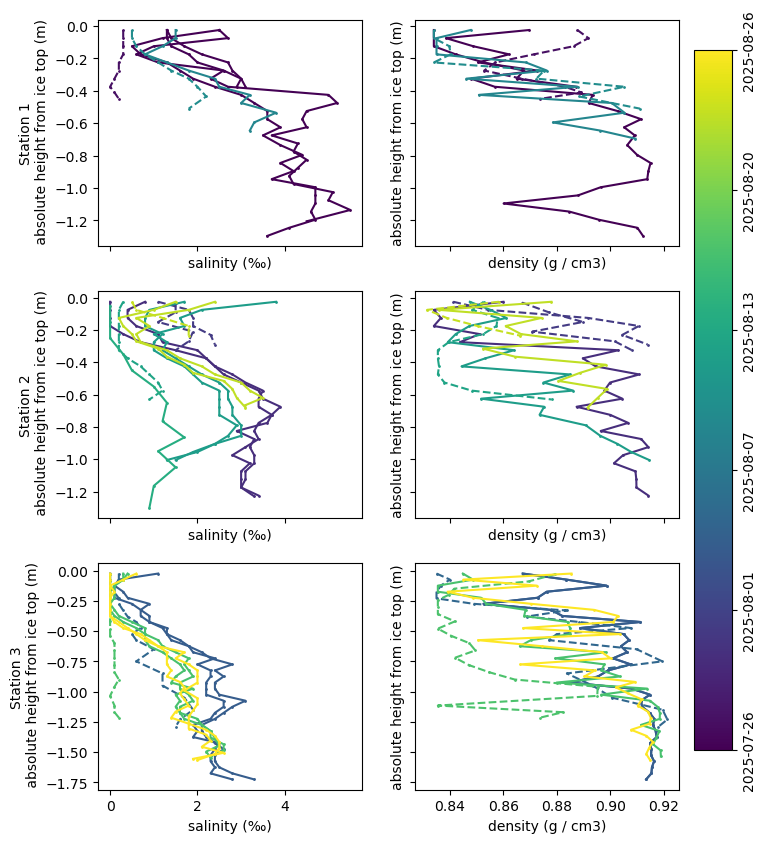

In [220]:
# Plot all salinities and densities
f, axs = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(7.5, 10))

stations = ['1', '2', '3']

z_ref = 'ice top'
z_scale = 'absolute'
pallette = 'viridis'
kind = 'center'
markersize = 1

cmap = cm.get_cmap(pallette)
min_time = df_cores.timestamp.min()
max_time = df_cores.timestamp.max()

for i, station in enumerate(stations):
    df_temp = df_cores.query('station == @station').reset_index()
    for tup in df_temp.itertuples():
        if tup[3] == '20250730-PS149_25-1-SI_corer_9cm-021-SMYI-RHO':
            continue # input is missing draft and freeboard, skip for now
        
        visit = tup[2]
        ic = tup[4]
        if ic.ponded:
            ls = 'dashed'
        else:
            ls = 'solid'
        color = cmap((tup[5] - min_time)/(max_time - min_time))
        if 'salinity' in ic.units:
            #print(tup[3])
            ic.plot_profile(axs[i,0], 'salinity', z_ref=z_ref,
                            z_scale=z_scale,
                            color=color, linestyle=ls,
                           kind=kind, markersize=markersize)
        if 'density' in ic.units:
            #print(tup[3])
            ic.plot_profile(axs[i,1], 'density', z_ref=z_ref,
                            z_scale=z_scale,
                            color=color, linestyle=ls,
                           kind=kind, markersize=markersize)
    # Update ylabel
    ylbl = axs[i,0].get_ylabel()
    axs[i,0].set_ylabel(f'Station {station}\n {ylbl}')

# Add colorbar
nticks = 6
f.subplots_adjust(right=0.9)
cbar_ax = f.add_axes([0.92, 0.15, 0.05, 0.7])
ticks = np.linspace(0, 1, nticks)
tick_labels = pd.date_range(start=min_time, end=max_time, periods=nticks
                           ).strftime('%Y-%m-%d').to_numpy()
f.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
           cax=cbar_ax, orientation='vertical',
          ticks=ticks, aspect=80, shrink=0.5)
cbar_ax.set_yticklabels(tick_labels, rotation=90, va="center")
plt.show()

f.savefig(os.path.join('..', 'figures', 
    f'contrasts_pond_sal_dens_{z_ref.replace(' ', '-')}_{z_scale}_{kind}.png'),
          bbox_inches='tight')

/tmp/ipykernel_103/3416312936.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(pallette)


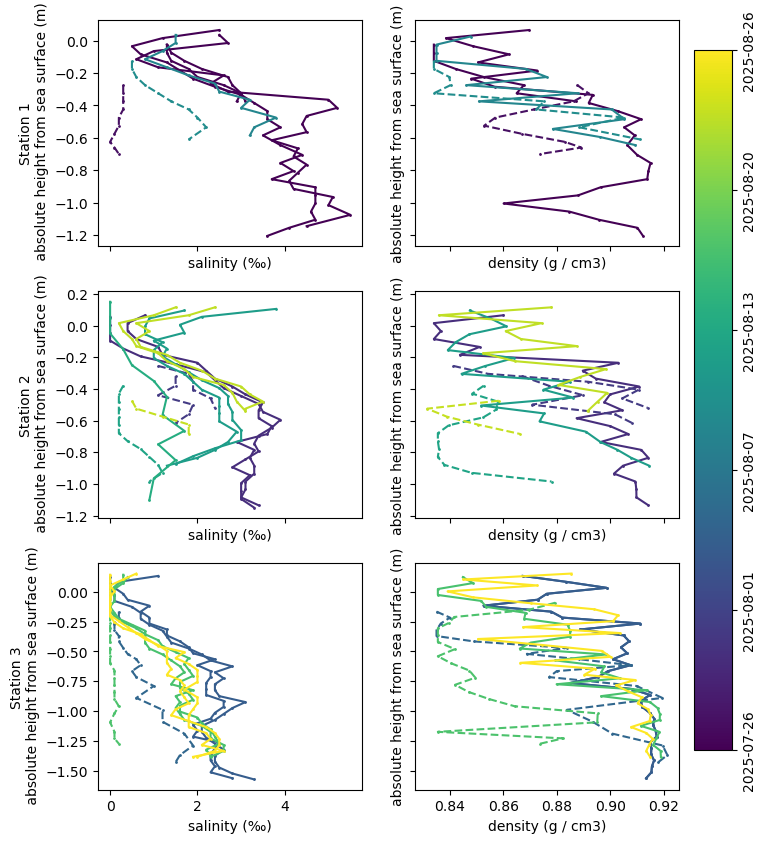

In [221]:
# Plot all salinities and densities
f, axs = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(7.5, 10))

stations = ['1', '2', '3']

z_ref = 'sea surface'
z_scale = 'absolute'
pallette = 'viridis'
kind = 'center'
markersize = 1

cmap = cm.get_cmap(pallette)
min_time = df_cores.timestamp.min()
max_time = df_cores.timestamp.max()

for i, station in enumerate(stations):
    df_temp = df_cores.query('station == @station').reset_index()
    for tup in df_temp.itertuples():
        if tup[3] == '20250730-PS149_25-1-SI_corer_9cm-021-SMYI-RHO':
            continue # input is missing draft and freeboard, skip for now
        
        visit = tup[2]
        ic = tup[4]
        if ic.ponded:
            ls = 'dashed'
        else:
            ls = 'solid'
        color = cmap((tup[5] - min_time)/(max_time - min_time))
        if 'salinity' in ic.units:
            #print(tup[3])
            ic.plot_profile(axs[i,0], 'salinity', z_ref=z_ref,
                            z_scale=z_scale,
                            color=color, linestyle=ls,
                           kind=kind, markersize=markersize)
        if 'density' in ic.units:
            #print(tup[3])
            ic.plot_profile(axs[i,1], 'density', z_ref=z_ref,
                            z_scale=z_scale,
                            color=color, linestyle=ls,
                           kind=kind, markersize=markersize)
    # Update ylabel
    ylbl = axs[i,0].get_ylabel()
    axs[i,0].set_ylabel(f'Station {station}\n {ylbl}')

# Add colorbar
nticks = 6
f.subplots_adjust(right=0.9)
cbar_ax = f.add_axes([0.92, 0.15, 0.05, 0.7])
ticks = np.linspace(0, 1, nticks)
tick_labels = pd.date_range(start=min_time, end=max_time, periods=nticks
                           ).strftime('%Y-%m-%d').to_numpy()
f.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
           cax=cbar_ax, orientation='vertical',
          ticks=ticks, aspect=80, shrink=0.5)
cbar_ax.set_yticklabels(tick_labels, rotation=90, va="center")
plt.show()

f.savefig(os.path.join('..', 'figures', 
    f'contrasts_pond_sal_dens_{z_ref.replace(' ', '-')}_{z_scale}_{kind}.png'),
          bbox_inches='tight')

/tmp/ipykernel_103/3837063539.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(pallette)


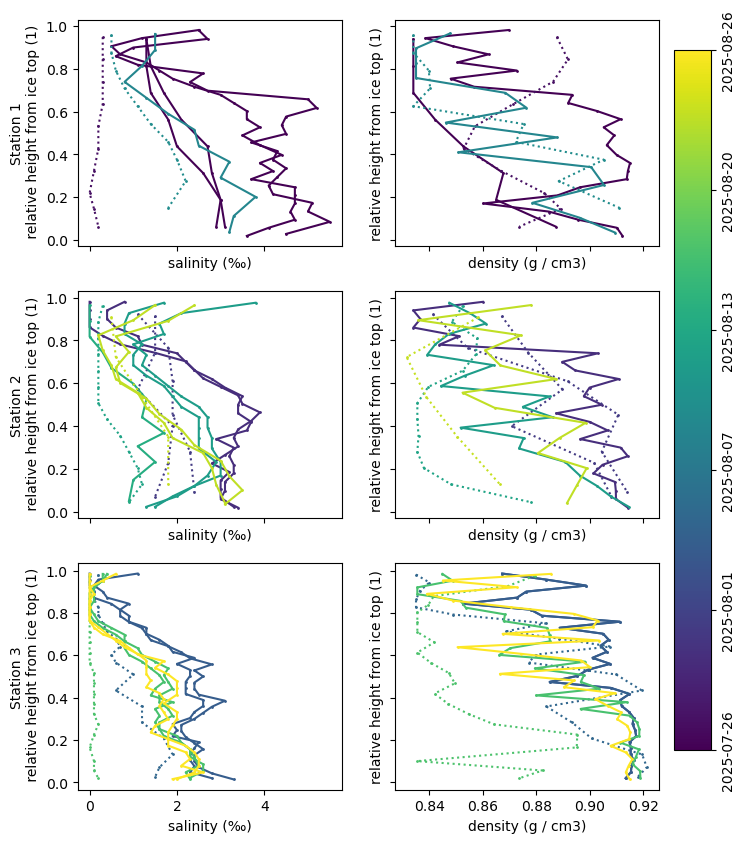

In [222]:
# Plot all salinities and densities
f, axs = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(7.5, 10))

stations = ['1', '2', '3']

z_ref = 'ice top'
z_scale = 'relative'
pallette = 'viridis'
kind = 'center'
markersize = 1

cmap = cm.get_cmap(pallette)
min_time = df_cores.timestamp.min()
max_time = df_cores.timestamp.max()

for i, station in enumerate(stations):
    df_temp = df_cores.query('station == @station').reset_index()
    for tup in df_temp.itertuples():
        if tup[3] == '20250730-PS149_25-1-SI_corer_9cm-021-SMYI-RHO':
            continue # input is missing draft and freeboard, skip for now
        
        visit = tup[2]
        ic = tup[4]
        if ic.ponded:
            ls = 'dotted'
        else:
            ls = 'solid'
        color = cmap((tup[5] - min_time)/(max_time - min_time))
        if 'salinity' in ic.units:
            #print(tup[3])
            ic.plot_profile(axs[i,0], 'salinity', z_ref=z_ref,
                            z_scale=z_scale,
                            color=color, linestyle=ls,
                           kind=kind, markersize=markersize)
        if 'density' in ic.units:
            #print(tup[3])
            ic.plot_profile(axs[i,1], 'density', z_ref=z_ref,
                            z_scale=z_scale,
                            color=color, linestyle=ls,
                           kind=kind, markersize=markersize)
    # Update ylabel
    ylbl = axs[i,0].get_ylabel()
    axs[i,0].set_ylabel(f'Station {station}\n {ylbl}')

# Add colorbar
nticks = 6
f.subplots_adjust(right=0.9)
cbar_ax = f.add_axes([0.92, 0.15, 0.05, 0.7])
ticks = np.linspace(0, 1, nticks)
tick_labels = pd.date_range(start=min_time, end=max_time, periods=nticks
                           ).strftime('%Y-%m-%d').to_numpy()
f.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
           cax=cbar_ax, orientation='vertical',
          ticks=ticks, aspect=80, shrink=0.5)
cbar_ax.set_yticklabels(tick_labels, rotation=90, va="center")
plt.show()

f.savefig(os.path.join('..', 'figures', 
    f'contrasts_pond_sal_dens_{z_ref.replace(' ', '-')}_{z_scale}_{kind}.png'),
          bbox_inches='tight')

/tmp/ipykernel_103/1793355155.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(pallette)


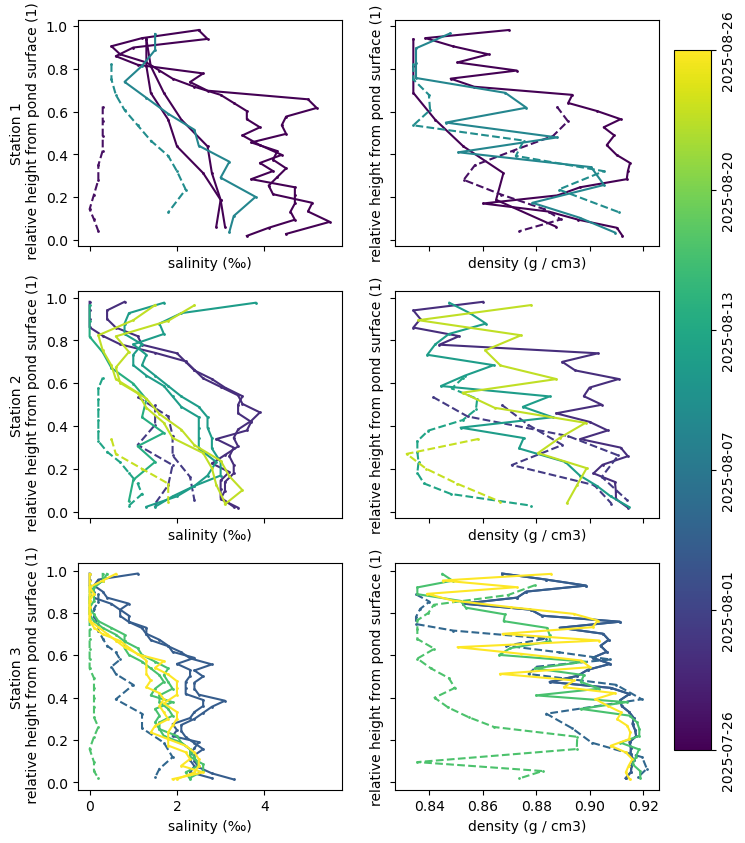

In [223]:
# Plot all salinities and densities
f, axs = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(7.5, 10))

stations = ['1', '2', '3']

z_ref = 'pond surface'
z_scale = 'relative'
pallette = 'viridis'
kind = 'center'
markersize = 1

cmap = cm.get_cmap(pallette)
min_time = df_cores.timestamp.min()
max_time = df_cores.timestamp.max()

for i, station in enumerate(stations):
    df_temp = df_cores.query('station == @station').reset_index()
    for tup in df_temp.itertuples():
        if tup[3] == '20250730-PS149_25-1-SI_corer_9cm-021-SMYI-RHO':
            continue # input is missing draft and freeboard, skip for now
        
        visit = tup[2]
        ic = tup[4]
        if ic.ponded:
            ls = 'dashed'
        else:
            ls = 'solid'
        color = cmap((tup[5] - min_time)/(max_time - min_time))
        if 'salinity' in ic.units:
            #print(tup[3])
            ic.plot_profile(axs[i,0], 'salinity', z_ref=z_ref,
                            z_scale=z_scale,
                            color=color, linestyle=ls,
                           kind=kind, markersize=markersize)
        if 'density' in ic.units:
            #print(tup[3])
            ic.plot_profile(axs[i,1], 'density', z_ref=z_ref,
                            z_scale=z_scale,
                            color=color, linestyle=ls,
                           kind=kind, markersize=markersize)
    # Update ylabel
    ylbl = axs[i,0].get_ylabel()
    axs[i,0].set_ylabel(f'Station {station}\n {ylbl}')

# Add colorbar
nticks = 6
f.subplots_adjust(right=0.9)
cbar_ax = f.add_axes([0.92, 0.15, 0.05, 0.7])
ticks = np.linspace(0, 1, nticks)
tick_labels = pd.date_range(start=min_time, end=max_time, periods=nticks
                           ).strftime('%Y-%m-%d').to_numpy()
f.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
           cax=cbar_ax, orientation='vertical',
          ticks=ticks, aspect=80, shrink=0.5)
cbar_ax.set_yticklabels(tick_labels, rotation=90, va="center")
plt.show()

f.savefig(os.path.join('..', 'figures', 
    f'contrasts_pond_sal_dens_{z_ref.replace(' ', '-')}_{z_scale}_{kind}.png'),
          bbox_inches='tight')

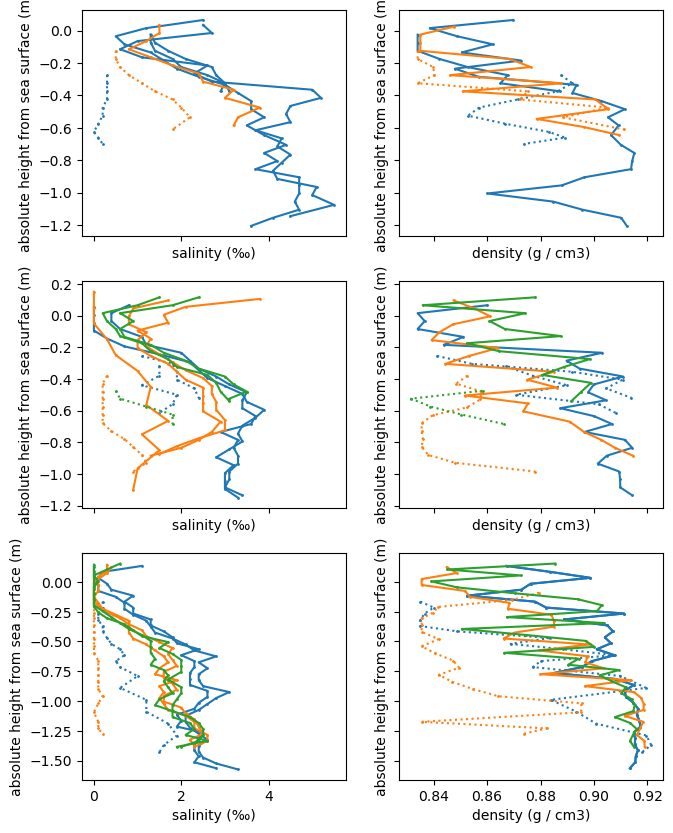

In [224]:
# Plot all salinities and densities
f, axs = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(7.5, 10))

stations = ['1', '2', '3']

color_dict = {'b': 'C0',
              'c': 'C1',
              'd': 'C2',
             }

kind = 'center'
markersize = 1

for i, station in enumerate(stations):
    df_temp = df_cores.query('station == @station').reset_index()
    for tup in df_temp.itertuples():
        if tup[3] == '20250730-PS149_25-1-SI_corer_9cm-021-SMYI-RHO':
            continue # input is missing draft and freeboard, skip for now
        
        visit = tup[2]
        ic = tup[4]
        if ic.ponded:
            ls = 'dotted'
        else:
            ls = 'solid'
        if 'salinity' in ic.units:
            #print(tup[3])
            ic.plot_profile(axs[i,0], 'salinity', z_ref='sea surface',
                            color=color_dict[visit], linestyle=ls,
                           kind=kind, markersize=markersize)
        if 'density' in ic.units:
            #print(tup[3])
            ic.plot_profile(axs[i,1], 'density', z_ref='sea surface',
                            color=color_dict[visit], linestyle=ls,
                           kind=kind, markersize=markersize)

In [278]:
# Summarize bulk properties
cores_exclude = ['20250726-PS149_21-1-SI_corer_9cm-020-FYI-lead-T',
                 '20250726-PS149_21-1-SI_corer_9cm-021-FYI-lead-SALO18',
                 '20250726-PS149_21-1-SI_corer_9cm-022-FYI-lead-RHO',
                 '20250730-PS149_25-1-SI_corer_9cm-021-SMYI-RHO',
                ]

ls_s = []
ls_r = []
ls_p = []
ls_a = []
df_temp = df_cores.query('name not in @cores_exclude')
for idx, ic in df_temp.core.items():
    if 'salinity' in ic.units:
        ls_s.append(ic.bulk_property('salinity'))
    else:
        ls_s.append(np.nan)
    if 'density' in ic.units:
        ls_r.append(ic.bulk_property('density'))
    else:
        ls_r.append(np.nan)
    ls_p.append(ic.ponded)
    ls_a.append(ic.age)
df_bulk = pd.DataFrame({'salinity': ls_s, 'density': ls_r, 
                        'ponded': ls_p, 'age': ls_a}, index=df_temp.index)
df_bulk.set_index(['ponded', 'age'], append=True, inplace=True)
df_bulk = df_bulk.melt(ignore_index=False).dropna(how='any')
df_bulk = df_bulk.reset_index().drop(columns=['name']).groupby(
    by=['station', 'visit', 'ponded', 'age', 'variable']).mean()

In [279]:
df_bulk

value
station visit ponded age              variable          
1       b     False  FY (first year)  density   0.887525
                                      salinity  3.489162
              True   FY (first year)  density   0.875120
                                      salinity  0.206250
        c     False  FY (first year)  density   0.870453
                                      salinity  2.314925
              True   FY (first year)  density   0.866960
                                      salinity  1.332727
2       b     False  FY (first year)  density   0.889040
                                      salinity  2.441778
              True   FY (first year)  density   0.886325
                                      salinity  1.739777
        c     False  FY (first year)  density   0.871245
                                      salinity  2.005825
                     SY (second year) salinity  0.803650
              True   SY (second year) density   0.847770
                                      salinity  0.521212
        d     False  FY (first year)  density   0.876995
                                      salinity  1.755215
              True   SY (second year) density   0.850345
                                      salinity  1.225926
3       b     False  SY (second year) density   0.901609
                                      salinity  1.794286
              True   SY (second year) density   0.886375
                                      salinity  0.870455
        c     False  SY (second year) density   0.888365
                                      salinity  1.257419
              True   SY (second year) density   0.854972
                                      salinity  0.055645
        d     False  SY (second year) density   0.892648
                                      salinity  1.209878

In [280]:
df_bulk.query('variable == "salinity"').reset_index().drop(columns='variable'
    ).pivot(index=['station','visit'], columns=['age', 'ponded'], values='value')

age           FY (first year)           SY (second year)          
ponded                  False     True             False     True 
station visit                                                     
1       b            3.489162  0.206250              NaN       NaN
        c            2.314925  1.332727              NaN       NaN
2       b            2.441778  1.739777              NaN       NaN
        c            2.005825       NaN         0.803650  0.521212
        d            1.755215       NaN              NaN  1.225926
3       b                 NaN       NaN         1.794286  0.870455
        c                 NaN       NaN         1.257419  0.055645
        d                 NaN       NaN         1.209878       NaN

In [281]:
df_bulk.query('variable == "density"').reset_index().drop(columns='variable'
    ).pivot(index=['station','visit'], columns=['age', 'ponded'], values='value')

age           FY (first year)           SY (second year)          
ponded                  False     True             True      False
station visit                                                     
1       b            0.887525  0.875120              NaN       NaN
        c            0.870453  0.866960              NaN       NaN
2       b            0.889040  0.886325              NaN       NaN
        c            0.871245       NaN         0.847770       NaN
        d            0.876995       NaN         0.850345       NaN
3       b                 NaN       NaN         0.886375  0.901609
        c                 NaN       NaN         0.854972  0.888365
        d                 NaN       NaN              NaN  0.892648

In [289]:
# Summarize bulk properties
cores_exclude = ['20250726-PS149_21-1-SI_corer_9cm-020-FYI-lead-T',
                 '20250726-PS149_21-1-SI_corer_9cm-021-FYI-lead-SALO18',
                 '20250726-PS149_21-1-SI_corer_9cm-022-FYI-lead-RHO',
                 '20250730-PS149_25-1-SI_corer_9cm-021-SMYI-RHO',
                ]

ls_s = []
ls_r = []
ls_p = []
ls_l = []
df_temp = df_cores.query('name not in @cores_exclude')
for idx, ic in df_temp.core.items():
    if 'salinity' in ic.units:
        ls_s.append(ic.bulk_property('salinity'))
    else:
        ls_s.append(np.nan)
    if 'density' in ic.units:
        ls_r.append(ic.bulk_property('density'))
    else:
        ls_r.append(np.nan)
    ls_p.append(ic.ponded)
    ls_l.append(ic.length)
df_bulk = pd.DataFrame({'salinity': ls_s, 'density': ls_r, 
                        'ponded': ls_p, 'length': ls_l}, index=df_temp.index)
df_bulk.set_index('ponded', append=True, inplace=True)
df_bulk = df_bulk.melt(ignore_index=False).dropna(how='any')
df_bulk = df_bulk.reset_index().drop(columns=['name']).groupby(
    by=['station', 'visit', 'ponded', 'variable']).mean()

In [290]:
df_bulk.reset_index().pivot(index=['station','visit'], columns=['variable', 'ponded'], 
                            values='value').sort_index(axis=1, level='variable')

variable        density              length         salinity          
ponded            False     True      False  True      False     True 
station visit                                                         
1       b      0.887525  0.875120  1.240000  0.480  3.489162  0.206250
        c      0.870453  0.866960  0.712500  0.600  2.314925  1.332727
2       b      0.889040  0.886325  1.408333  0.335  2.441778  1.739777
        c      0.871245  0.847770  1.102000  0.660  1.605100  0.521212
        d      0.876995  0.850345  0.730000  0.270  1.755215  1.225926
3       b      0.901609  0.886375  1.750000  1.325  1.794286  0.870455
        c      0.888365  0.854972  1.560000  1.240  1.257419  0.055645
        d      0.892648       NaN  1.587500    NaN  1.209878       NaN

In [313]:
## rough freeboard estimation
s_frac = pd.Series([0.7, 0.3], index=pd.Index([False, True], name='ponded'), name='fraction')
df_temp_true = pd.merge(df_bulk.query('variable in ["density", "length"]').reset_index(level='variable').pivot(columns='variable', values='value'),
                        s_frac, left_index=True, right_index=True)
# phi_i is volume fraction ice, could make different for ponded and unponded
df_temp_true['phi_i'] = 0.9

# Pond buoyancy force is how many kg of ice per m2 the pond can support
rhow = 1026
df_pond_buoy = ((rhow - df_temp_true['density']*1e3)*df_temp_true['length']*df_temp_true['fraction']*df_temp_true['phi_i']
    ).reset_index('ponded').query('ponded').drop(columns='ponded').rename(columns={0: 'pond_ice_buoyancy_kg_m2'})

df_temp_true = pd.merge(df_temp_true.query('not ponded').reset_index('ponded', drop=True),
                        df_pond_buoy, left_index=True, right_index=True)

df_temp_true['bi_fbd_m'] = (df_temp_true['length']*(rhow - df_temp_true['density']*1e3)/rhow 
                            + df_temp_true['pond_ice_buoyancy_kg_m2']/(df_temp_true['fraction']*df_temp_true['phi_i']*rhow))
df_temp_true['fbd_m'] = df_temp_true['bi_fbd_m'] * df_temp_true['fraction']
#df_temp_true['mass_per_m2'] = 1000*df_temp_true['density']*df_temp_true['length']

In [314]:
df_temp_true

density    length  fraction  phi_i  pond_ice_buoyancy_kg_m2  \
station visit                                                                 
1       b      0.887525  1.240000       0.7    0.9                19.554059   
        c      0.870453  0.712500       0.7    0.9                25.764522   
2       b      0.889040  1.408333       0.7    0.9                12.633587   
        c      0.871245  1.102000       0.7    0.9                31.760604   
        d      0.876995  0.730000       0.7    0.9                12.805283   
3       b      0.901609  1.750000       0.7    0.9                49.950803   
        c      0.888365  1.560000       0.7    0.9                57.260161   

               bi_fbd_m     fbd_m  
station visit                      
1       b      0.197609  0.138326  
        c      0.147879  0.103515  
2       b      0.207543  0.145280  
        c      0.215354  0.150748  
        d      0.125828  0.088080  
3       b      0.289446  0.202612  
        c      0.297856  0.208499

In [326]:
## rough freeboard estimation
s_frac = pd.Series([0.7, 0.3], index=pd.Index([False, True], name='ponded'), name='fraction')
df_temp = df_bulk.query('variable == "density" & not ponded').reset_index()
df_temp['ponded'] = True
df_temp = df_temp.set_index(['station', 'visit', 'ponded', 'variable']).combine_first(df_bulk)
df_temp_wrongpond = pd.merge(df_temp.query('variable in ["density", "length"]').reset_index(level='variable').pivot(columns='variable', values='value'),
                        s_frac, left_index=True, right_index=True)
# phi_i is volume fraction ice, could make different for ponded and unponded
df_temp_wrongpond['phi_i'] = 0.9

# Pond buoyancy force is how many kg of ice per m2 the pond can support
rhow = 1026
df_pond_buoy = ((rhow - df_temp_wrongpond['density']*1e3)*df_temp_wrongpond['length']*df_temp_wrongpond['fraction']*df_temp_wrongpond['phi_i']
    ).reset_index('ponded').query('ponded').drop(columns='ponded').rename(columns={0: 'pond_ice_buoyancy_kg_m2'})

df_temp_wrongpond = pd.merge(df_temp_wrongpond.query('not ponded').reset_index('ponded', drop=True),
                        df_pond_buoy, left_index=True, right_index=True)

df_temp_wrongpond['bi_fbd_m'] = (df_temp_wrongpond['length']*(rhow - df_temp_wrongpond['density']*1e3)/rhow 
                            + df_temp_wrongpond['pond_ice_buoyancy_kg_m2']/(df_temp_wrongpond['fraction']*df_temp_wrongpond['phi_i']*rhow))
df_temp_wrongpond['fbd_m'] = df_temp_wrongpond['bi_fbd_m'] * df_temp_wrongpond['fraction']
#df_temp_true['mass_per_m2'] = 1000*df_temp_true['density']*df_temp_true['length']

In [327]:
df_temp_wrongpond

density    length  fraction  phi_i  pond_ice_buoyancy_kg_m2  \
station visit                                                                 
1       b      0.887525  1.240000       0.7    0.9                17.946331   
        c      0.870453  0.712500       0.7    0.9                25.198665   
2       b      0.889040  1.408333       0.7    0.9                12.388052   
        c      0.871245  1.102000       0.7    0.9                27.577318   
        d      0.876995  0.730000       0.7    0.9                10.862490   
3       b      0.901609  1.750000       0.7    0.9                44.500888   
        c      0.888365  1.560000       0.7    0.9                46.080328   
        d      0.892648  1.587500       0.7    0.9                      NaN   

               bi_fbd_m     fbd_m  
station visit                      
1       b      0.195122  0.136585  
        c      0.147003  0.102902  
2       b      0.207163  0.145014  
        c      0.208882  0.146218  
        d      0.122823  0.085976  
3       b      0.281014  0.196710  
        c      0.280560  0.196392  
        d           NaN       NaN

In [241]:
# Testing class
station = '1'
visit = 'b'

filepaths = glob.glob(os.path.join(ic_data_root, f"IceStation{station}{visit}", '**', '[!~]*.xlsx'))

In [242]:
filepaths

['../data/ice_coring/IceStation1b/26jul2025coring/20250726-PS149_21-1-SI_corer_9cm-016-FYI-T.xlsx',
 '../data/ice_coring/IceStation1b/26jul2025coring/20250726-PS149_21-1-SI_corer_9cm-017-FYI-REP.xlsx',
 '../data/ice_coring/IceStation1b/26jul2025coring/20250726-PS149_21-1-SI_corer_9cm-018-FYI-SALO18.xlsx',
 '../data/ice_coring/IceStation1b/26jul2025coring/20250726-PS149_21-1-SI_corer_9cm-019-FYI-RHO.xlsx',
 '../data/ice_coring/IceStation1b/26jul2025coring/20250726-PS149_21-1-SI_corer_9cm-020-FYI-lead-T.xlsx',
 '../data/ice_coring/IceStation1b/26jul2025coring/20250726-PS149_21-1-SI_corer_9cm-021-FYI-lead-SALO18.xlsx',
 '../data/ice_coring/IceStation1b/26jul2025coring/20250726-PS149_21-1-SI_corer_9cm-022-FYI-lead-RHO.xlsx',
 '../data/ice_coring/IceStation1b/27jul2025coring_melt_pond/20250727-PS149_21-1-SI_corer_9cm-023-FYI-melt_pond-RHO.xlsx']

In [243]:
self = IceCore(station, visit, filepaths[7])

In [244]:
self.load_salinity()

/tmp/ipykernel_103/3007439211.py:153: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.data = pd.concat([self.data, df_data_temp])


In [245]:
self.load_densimetry()

In [246]:
self.bulk_property('salinity')

0.20625

In [232]:
self.data

value
variable depth_top depth_bottom depth_center          
salinity 0.0       0.05         0.025         0.300000
         0.05      0.1          0.075         0.300000
         0.1       0.15         0.125         0.300000
         0.15      0.2          0.175         0.300000
         0.2       0.25         0.225         0.200000
         0.25      0.3          0.275         0.200000
         0.3       0.35         0.325         0.100000
         0.35      0.4          0.375         0.000000
         0.4       0.42         0.41          0.100000
         0.42      0.48         0.45          0.200000
density  0.0       0.05         0.025         0.887701
         0.05      0.1          0.075         0.891841
         0.1       0.15         0.125         0.886287
         0.15      0.2          0.175         0.871442
         0.2       0.25         0.225         0.857036
         0.25      0.3          0.275         0.852846
         0.3       0.35         0.325         0.866869
         0.35      0.4          0.375         0.883019
         0.4       0.42         0.41          0.889191
         0.42      0.48         0.45          0.873695

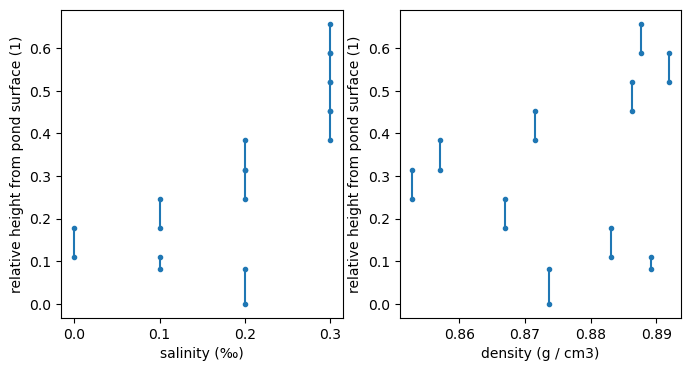

In [128]:
# Test plotting
f, axs = plt.subplots(1, 2, figsize=(8, 4))

z_ref = 'pond surface'#'sea surface'#'ice top'#
z_scale = 'relative'#'absolute'#
kind = 'segment'#'center'
markersize = 3

ax = axs[0]
variable = 'salinity'
self.plot_profile(ax, variable, z_ref=z_ref, z_scale=z_scale, kind=kind,
                 markersize=markersize)

ax = axs[1]
variable = 'density'
self.plot_profile(ax, variable, z_ref=z_ref, z_scale=z_scale, kind=kind,
                 markersize=markersize)